In [1]:
import qctoolkit as qtk
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import clear_output

%matplotlib inline

/home/samio/local/miniconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from horton import GOBasisFamily
#basis = GOBasisFamily('basis', filename='basis/sto2g/H_Ne_uncontracted.nwchem')
#basis = '3-21g'
#basis = 'sto-3g'
#basis = GOBasisFamily('basis', filename='basis/sto6g/H_Ne.nwchem')
basis = GOBasisFamily('basis', filename='basis/sto6g/H_Be-s.nwchem')

In [3]:
mol = qtk.Molecule()
mol.build([[1,0,0,0], [1,0.74,0,0]])
mol = qtk.QMInp(mol, program='horton', basis_set=basis)

In [4]:
mol.run()

-1.1278603719867697

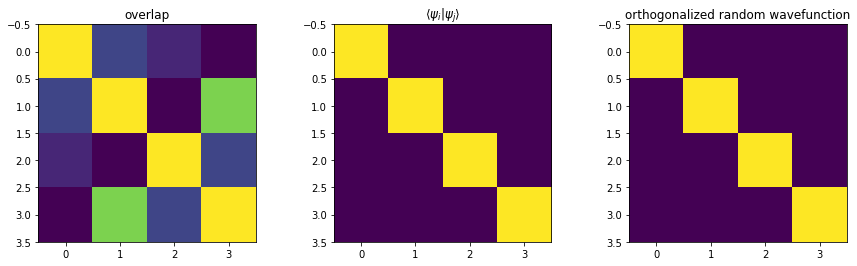

In [5]:
fig, axarr = plt.subplots(1, 3, figsize=(15,4))

axarr[0].imshow(mol.olp)

C = mol.mov
axarr[1].imshow(C.T.dot(mol.olp).dot(C))

# canonical orthogonalization transformation matirx
D, U = np.linalg.eigh(mol.olp)
X = U.dot(np.diag(1/np.sqrt(D)))

# random MO coefficients
B = np.random.random(U.shape)
#_, B = np.linalg.eig(B.T.dot(B))
# orthonormalized MO coefficients
C0 = np.linalg.eigh(B.T.dot(B))[1]
C = X.dot(np.linalg.eig(B.T.dot(B))[1])
#C = X.dot(B)
#C = np.linalg.inv(X).dot(B)

# orthonormalized random MO coefficients
axarr[2].imshow(C.T.dot(mol.olp).dot(C))

axarr[0].set_title('overlap')
axarr[1].set_title(r'$\langle\psi_i|\psi_j\rangle$')
axarr[2].set_title('orthogonalized random wavefunction')
pass

In [6]:
inps = []
for R in np.arange(0.3, 3.1, 0.005):
    mol = qtk.Molecule()
    mol.build([[1, 0, 0, 0], [1, R, 0, 0]])
    inp = qtk.QMInp(mol, program='horton', basis_set=basis)
    inp.run()
    D, U = np.linalg.eigh(inp.olp)
    inp.X = U / np.sqrt(D)
    inps.append(inp)
clear_output()

504 56


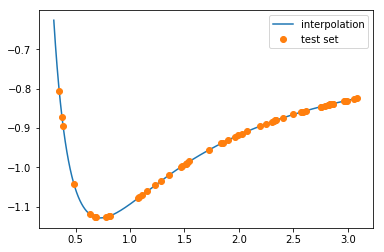

In [7]:
from sklearn.model_selection import train_test_split

inp_train, inp_test = train_test_split(inps, random_state=0, test_size=0.1)

E = [inp.ht_ham.cache['energy'] for inp in inps]
R = [inp.molecule.R[1,0] for inp in inps]
E_train = [inp.ht_ham.cache['energy'] for inp in inp_train]
R_train = [inp.molecule.R[1,0] for inp in inp_train]
E_test = [inp.ht_ham.cache['energy'] for inp in inp_test]
R_test = [inp.molecule.R[1,0] for inp in inp_test]

plt.plot(R, E, label='interpolation')
plt.plot(R_test, E_test, ls='', marker='o', label='test set')
#plt.plot(R_train, E_train, ls='', marker='x', label='training set')
plt.legend(loc=1)
print len(E_train), len(E_test)

In [8]:
# Numpy version implementation

def get_input_tensor(mol):
    """Extract matrices and pack as tensor"""
    S, K, Na, C0, X, Er = mol.olp, mol.kin, mol.na, mol.initial_mov, mol.X, mol.er
    I = np.stack([S, K, Na, C0, X])
    nn = mol.ht_external['nn']
    occ = mol.ht_exp_alpha.occupations
    return I, Er, occ, nn
    
def get_output(I, Er, occ, nn, C):
    """take input tensor and approximated MO coefficients, C, to compute total energy"""
    K = I[1]
    Na = I[2]
    dm = (C * occ).dot(C.T)
    
    Ek = np.trace(dm.dot(K)) * 2
    Ev = np.trace(dm.dot(Na)) * 2
    Ej = np.trace(dm.dot(np.tensordot(dm, Er, axes=([0,1], [0,2])))) * 2
    Ex = -np.trace(dm.dot(np.tensordot(dm, Er, axes=([0,1], [0,1]))))
    E_tot = np.sum([Ek, Ev, Ej, Ex, nn])
    return E_tot

inp = inps[0]
I_np, Er_np, occ, nn = get_input_tensor(inp)
C = inp.ht_exp_alpha.coeffs.__array__()
get_output(I_np, Er_np, occ, nn, C)

-0.6266249707016902

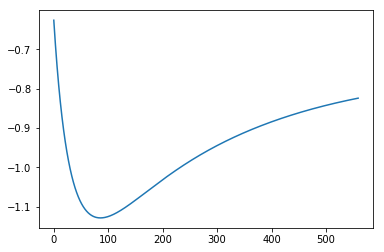

In [9]:
def tfIO(mol_list):
    I_list, Er_list, occ_list, nn_list, C_list, labels = [[] for _ in range(6)]
    for mol in mol_list:
        C = mol.ht_exp_alpha.coeffs.__array__()
        C_list.append(C)
        I, Er, occ, nn = get_input_tensor(mol)
        I_list.append(I)
        Er_list.append(Er)
        occ_list.append(occ)
        nn_list.append(nn)
        labels.append(get_output(I, Er, occ, nn, C))
        
    return np.stack(I_list).astype(np.float32), np.stack(Er_list).astype(np.float32), \
           np.stack(occ_list).astype(np.float32), np.stack(nn_list).astype(np.float32), \
           np.stack(C_list).astype(np.float32), np.stack(labels).astype(np.float32)
        
I_train, Er_train, occ_train, nn_train, C_train, y_train = tfIO(inp_train)
I_test, Er_test, occ_test, nn_test, C_test, y_test = tfIO(inp_test)
_, _, _, _, _, y = tfIO(inps)
plt.plot(y)

In [10]:
print I_train.shape
print Er_train.shape
print occ_train.shape
print nn_train.shape

(504, 5, 4, 4)
(504, 4, 4, 4, 4)
(504, 4)
(504,)


In [11]:
import tensorflow as tf

In [12]:
X_train = dict(
    input=I_train,
    Er=Er_train,
    occ=occ_train,
    nn=nn_train,
)

X_test = dict(
    input=I_test,
    Er=Er_test,
    occ=occ_test,
    nn=nn_test,
)

Y_train = {'targets': y_train}
Y_test = {'targets': y_test}

In [13]:
def lrelu(x, alpha):
    """Leaky ReLU activation function"""
    return tf.nn.relu(x) - alpha * tf.nn.relu(-x)

def flatten_custom(x_tensor):
    """reshape stacked channels in to flatten nodes for fully connected layer"""

    if type(x_tensor) is np.ndarray:
        shape = x_tensor.shape
    else:
        shape = x_tensor.get_shape().as_list()

    flatten_shape = np.prod(shape[1:])

    return tf.reshape(x_tensor, [-1, flatten_shape])

def SCF_fc_layer(I, C_prd=None, keep_prob=1.0, sess=None, N_layer=0, reg_scale=None):
    """fully connected layers to map S, K, V, Er_j, Er_x, C_prd_old to C_prd_new"""

    # use initial guess if C_prd is not provided
    if C_prd is None:
        C_prd = I[:,-2]
        shape = C_prd.shape[-2:]
    else:
        shape = C_prd.get_shape()[-2:]

    if reg_scale is not None:
        regularizer = tf.contrib.layers.l2_regularizer(scale=reg_scale)
    else:
        regularizer = None
    # features extracted from molecular Hamiltonian
    S, K, V, Er_j, Er_x = (I[:,i] for i in range(5))

    shape_product = int(S.shape[1] * S.shape[2])
    input_flatten = flatten(tf.stack((S, K, V, Er_j, Er_x, C_prd), axis=1))
    for _ in range(N_layer):
        input_flatten = tf.contrib.layers.fully_connected(
            input_flatten,
            input_flatten.get_shape().as_list()[-1],
            weights_regularizer = regularizer
        )
    C_added = tf.contrib.layers.fully_connected(
        input_flatten,
        shape_product,
        weights_regularizer = regularizer
    )
    # leaky relu is used to ensure no zero eigen values
    C_out = lrelu(tf.reshape(C_added , [-1, tf.shape(C_prd)[1], tf.shape(C_prd)[2]]), 0.1)
    C_out = tf.nn.dropout(C_out, keep_prob=keep_prob)
    C_out.set_shape(S.get_shape())

    return C_out

def orthogonal_fc_layer(I, C_prd=None, keep_prob=1.0, N_layer=1):
    """
    orthogonalize predicted MO coefficients, C_prd
    some flexibility seems to be necessary to overfit to H2 system
    """
    input_flatten = flatten(C_prd)

    itr = 0
    for _ in range(N_layer):
        Wn = tf.Variable(tf.truncated_normal(
            (input_flatten.get_shape().as_list()[-1], input_flatten.get_shape().as_list()[-1]),
            dtype=tf.float64
        ), dtype=tf.float64, name='weights_n')
        bn = tf.Variable(tf.zeros(
            input_flatten.get_shape().as_list()[-1], dtype=tf.float64
        ), dtype=tf.float64, name='biases_n')

        input_flatten = tf.add(tf.matmul(input_flatten, Wn), bn)

        if itr < N_layer - 1:
            input_flatten = tf.nn.dropout(input_flatten, keep_prob=keep_prob)

        itr += 1

    C_new = tf.reshape(
        input_flatten,
        [-1, tf.shape(C_prd)[1], tf.shape(C_prd)[2]]
    )

    C_sym = tf.matmul(tf.transpose(C_new, perm=[0,2,1]), C_new)
    C_sym.set_shape(I[:,0].get_shape())


    _, C_out = tf.self_adjoint_eig(C_sym)
    C_out.set_shape(I[:,0].get_shape())

    return tf.matmul(I[:,-1], C_out)

def HF_energy_layer(I, Er=None, occ=None, nn=None, C_prd=None):
    """return predicted energy from predicted MO coefficients C_prd"""
    K, Na = I[:,1], I[:,2]

    batch = tf.shape(I)[0]
    C_occ = tf.multiply(tf.expand_dims(occ, 1), C_prd)
    dm = tf.matmul(C_occ, tf.transpose(C_prd, perm=[0,2,1]))

    ind = tf.transpose(tf.stack([tf.range(batch), tf.range(batch)]))
    J_kernel = tf.gather_nd(tf.tensordot(dm, Er, axes=([1,2], [1,3])), ind)
    X_kernel = tf.gather_nd(tf.tensordot(dm, Er, axes=([1,2], [1,2])), ind)

    Ek = tf.trace(tf.matmul(dm, K)) * 2
    Ev = tf.trace(tf.matmul(dm, Na)) * 2
    Ej = tf.trace(tf.matmul(dm, J_kernel)) * 2
    Ex = -tf.trace(tf.matmul(dm, X_kernel))

    E_total = tf.add(Ek, Ev)
    E_total = tf.add(E_total, Ej)
    E_total = tf.add(E_total, Ex)
    E_total = tf.add(E_total, nn)

    return E_total

In [14]:
import tflearn
import tensorflow as tf
from tflearn.layers.conv import conv_1d, conv_2d, conv_2d_transpose
from tflearn.layers.core import input_data, dropout, fully_connected, flatten, custom_layer
from tflearn.layers.estimator import regression

In [15]:
def set_model():

    tf.reset_default_graph()

    I_holder = input_data(shape=[None, 5, 4, 4], name='input', dtype=tf.float64)
    Er_holder = input_data(shape=[None, 4, 4, 4, 4], name='Er', dtype=tf.float64)
    occ_holder = input_data(shape=[None, 4], name='occ', dtype=tf.float64)
    nn_holder = input_data(shape=[None, ], name='nn', dtype=tf.float64)

    C = custom_layer(I_holder, SCF_fc_layer)
    for _ in range(2):
        C = custom_layer(I_holder, SCF_fc_layer, C_prd=C)
    C = dropout(C, 0.8)
    for _ in range(2):
        C = custom_layer(I_holder, SCF_fc_layer, C_prd=C)

    # normalizatoin layers for prediction orthogonalization
    C = custom_layer(I_holder, orthogonal_fc_layer, C_prd=C)
    C_prd = custom_layer(I_holder, orthogonal_fc_layer, C_prd=C)

    # output layer to compute final energy
    y_prd = custom_layer(I_holder, HF_energy_layer, Er=Er_holder, occ=occ_holder, nn=nn_holder, C_prd=C_prd)
    energy_loss = regression(y_prd, optimizer='adam', learning_rate=0.001, loss='mean_square' , name='targets', dtype=tf.float64)

    # reference for multiple graph management
    # https://www.tensorflow.org/programmers_guide/graphs#programming_with_multiple_graphs
    g = tf.get_default_graph()
    return C_prd, y_prd, energy_loss, g

In [16]:
new_run = True

C, y, loss, g = set_model()
with tf.Session(graph=g) as sess:
    model = tflearn.DNN(loss, tensorboard_dir="logs", session=sess)
    if new_run:
        # start new training
        sess_train.run(tf.global_variables_initializer())
    else:
        # load pretrained model
        model.load('H2_test')
        
    model.fit(
        X_train, Y_train,
        n_epoch=1, batch_size=1,
        validation_set=0.1,
        show_metric=True, 
        run_id='test', 
    )
    model.save('H2_test')

Training Step: 24914  | total loss: 0.00001 | time: 1.933s
| Adam | epoch: 001 | loss: 0.00001 -- iter: 452/453
Training Step: 24915  | total loss: 0.00001 | time: 2.980s
| Adam | epoch: 001 | loss: 0.00001 | val_loss: 0.00001 -- iter: 453/453
--
INFO:tensorflow:/home/samio/Works/postPhD/Basel/projects/02_QM_AI/06_TFLearn_reimplement/H2_test is not in all_model_checkpoint_paths. Manually adding it.


In [17]:
C, y, loss, g = set_model()
with tf.Session(graph=g) as sess:
    model = tflearn.DNN(loss, tensorboard_dir="logs", session=sess)
    model.load('H2_test')
    y_prds = model.predict(X_test)

INFO:tensorflow:Restoring parameters from /home/samio/Works/postPhD/Basel/projects/02_QM_AI/06_TFLearn_reimplement/H2_test


In [18]:
C, y, loss, g = set_model()
with tf.Session(graph=g) as sess:
    model = tflearn.DNN(C, tensorboard_dir="logs", session=sess)
    model.load('H2_test')
    C_prds = model.predict(X_test)

INFO:tensorflow:Restoring parameters from /home/samio/Works/postPhD/Basel/projects/02_QM_AI/06_TFLearn_reimplement/H2_test


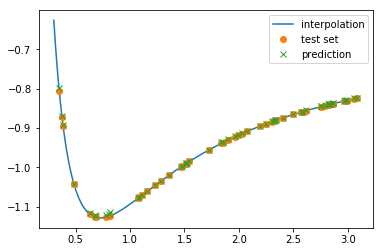

In [19]:
plt.plot(R, E, label='interpolation')
plt.plot(R_test, y_test, ls='', marker='o', label='test set')
plt.plot(R_test, y_prds, ls='', marker='x', label='prediction')
plt.legend()

In [20]:
q_tar_list = []
q_prd_list = []
for i in range(10):
    inp = inp_test[i]
    Cp = C_prds[i]
    dm_tar = inp.dm()
    dm_prd = inp.dm(Cp)
    q_tar_list.append(inp.getRhoCube())
    q_prd_list.append(inp.getRhoCube(dm=dm_prd))

In [21]:
def plot_ind(ind):
    qtk.setting.quiet=True
    fig, axarr = plt.subplots(1, 2, figsize=(15,4))
    qtar = q_tar_list[ind]
    qprd = q_prd_list[ind]
    contour_setting = dict(
        axis=1,
        fig=fig,
        levels=np.linspace(-0.02, 0.3, 30)
    )
    plot_data = qtar.contour(ax=axarr[0], **contour_setting)
    plot_data = qprd.contour(ax=axarr[1], **contour_setting)
    #plot_data = (qprd - qtar).contour(ax=axarr[2], **contour_setting)
    axarr[0].set_title(r'$E_{\rm tar}=%.6f$ [a.u]' % y_test[ind])
    axarr[1].set_title(r'$E_{\rm prd}=%.6f$ [a.u]' % y_prds[ind])
    qtk.setting.quiet=False

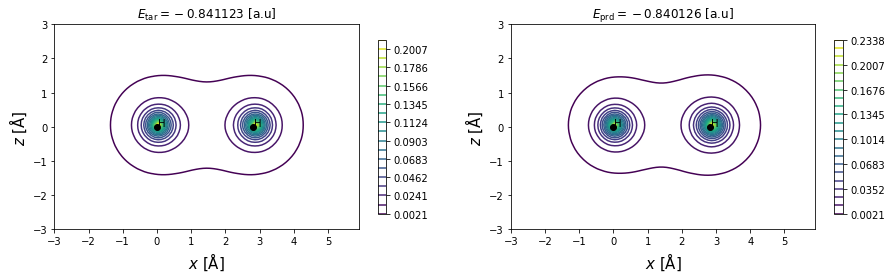

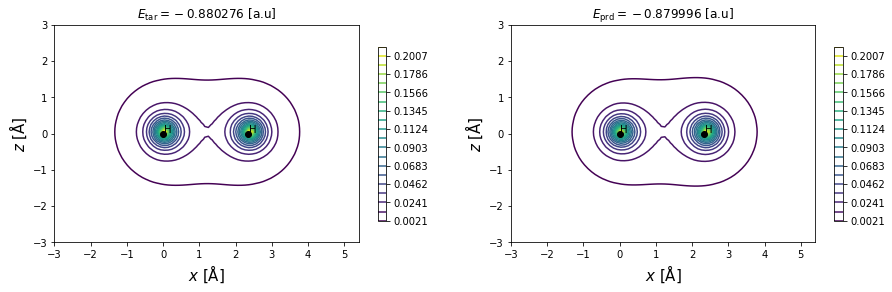

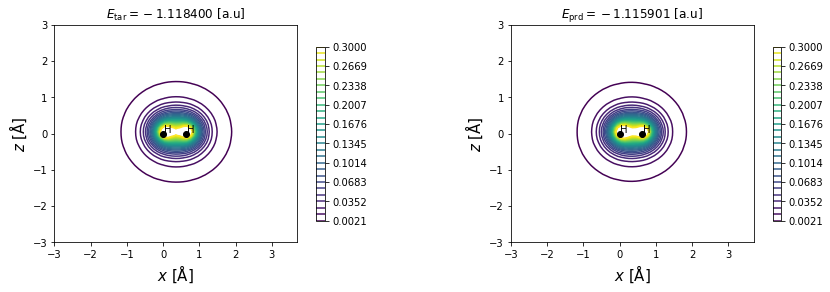

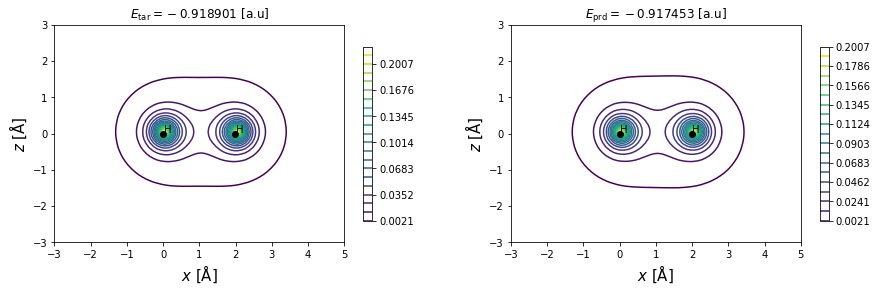

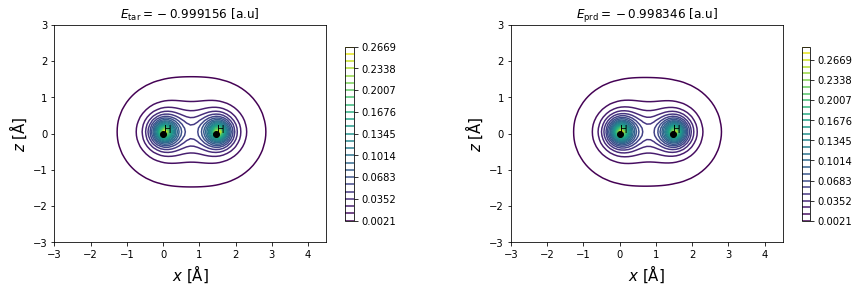

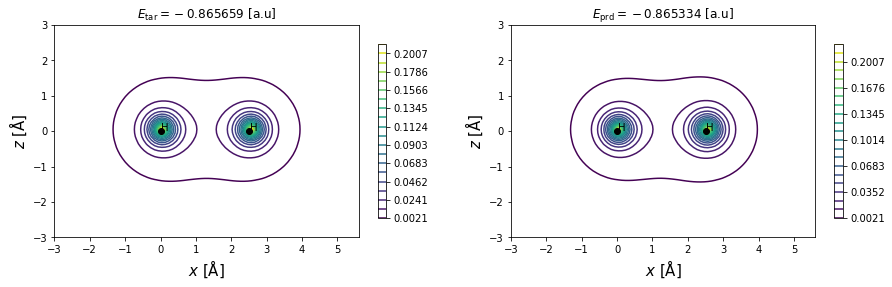

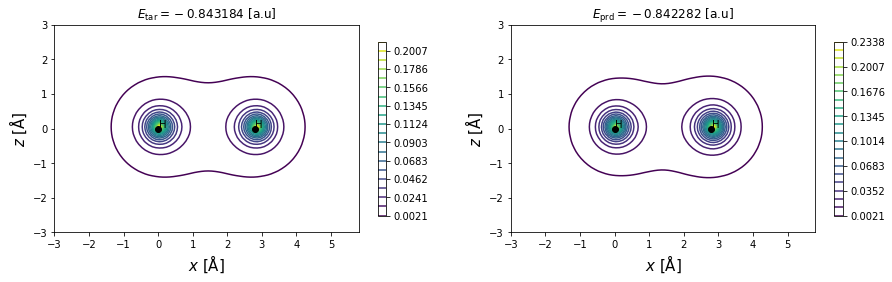

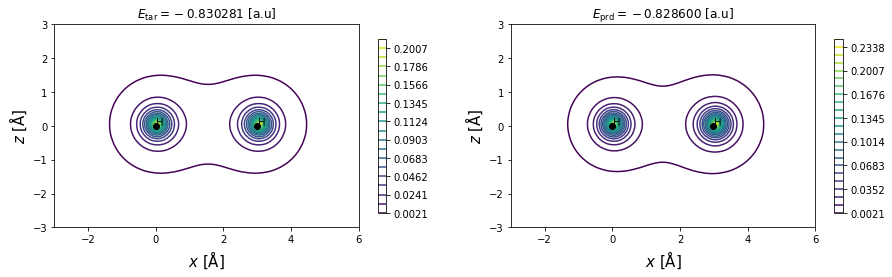

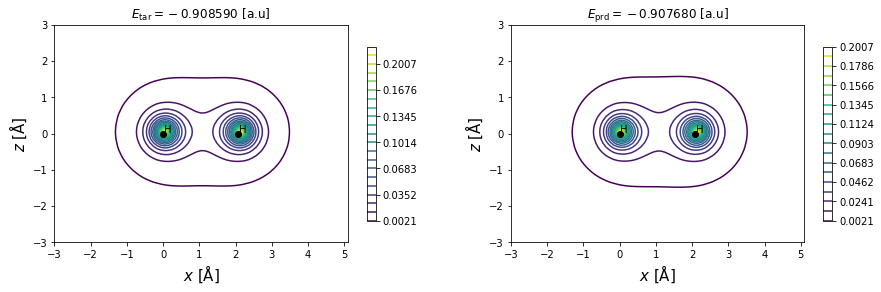

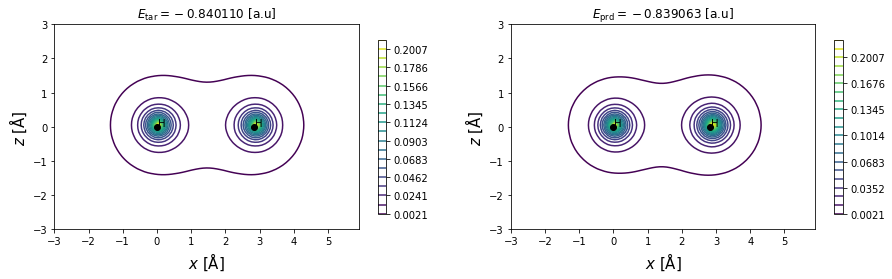

In [22]:
for i in range(len(q_tar_list)):
    plot_ind(i)